[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/chatbot-external-memory.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239440-lesson-6-chatbot-w-summarizing-messages-and-external-memory)

# Чат-бот с суммаризацией сообщений и внешней памятью БД

## Итоги предыдущего раздела

Мы рассмотрели, как настраивать схему состояния графа и редьюсеры.

Также мы показали несколько приемов для очистки или фильтрации сообщений в состоянии графа.

Мы применили эти концепции в чат-боте с памятью, который создает текущую суммаризацию диалога.

## Цели текущего раздела

Но что, если мы хотим, чтобы наш чат-бот имел память, которая сохраняется неограниченно долго?

Теперь мы представим более продвинутые механизмы контрольных точек, поддерживающие внешние базы данных.

Здесь мы покажем, как использовать [Sqlite в качестве механизма контрольных точек](https://docs.langchain.com/oss/python/langgraph/persistence#checkpointer-libraries), но доступны и другие варианты, например Postgres!

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph-checkpoint-sqlite langchain_core langgraph langchain_mistralai

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("MISTRAL_API_KEY")

MISTRAL_API_KEY:  ········


## Sqlite

Хорошей отправной точкой здесь является механизм контрольных точек [SqliteSaver](https://docs.langchain.com/oss/python/langgraph/persistence#checkpointer-libraries).

Sqlite — это [компактная, быстрая, очень популярная](https://x.com/karpathy/status/1819490455664685297) SQL-база данных.

Если мы укажем `":memory:"`, она создаст базу данных Sqlite в оперативной памяти.

In [1]:
import sqlite3
# База данных в памяти
conn = sqlite3.connect(":memory:", check_same_thread = False)

Но если мы укажем путь к базе данных, то она создаст базу данных для нас!

In [2]:
# Скачайте файл если его еще нет и подключитесь к базе
!mkdir -p state_db && [ ! -f state_db/example.db ] && wget -P state_db https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db

db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

In [3]:
# Это наш чекпоинтер
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)

Давайте переопределим нашего чат-бота.

In [4]:
from typing_extensions import Literal
from langchain_mistralai import ChatMistralAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.graph import END
from langgraph.graph import MessagesState


model = ChatMistralAI(model="mistral-small-latest",temperature=0)

class State(MessagesState):
    summary: str

# Определим логику вызова модели
def call_model(state: State):
    
    # Получим сводку если она еще есть
    summary = state.get("summary", "")

    # Если есть сводка, то мы ее добавляем
    if summary:
        
        # Добавляем сводку в системное сообщение
        system_message = f"Summary of conversation earlier: {summary}"

        # Добавляем сводку к новому сообщению
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # Сначала получаем сводку
    summary = state.get("summary", "")

    # Создаем промпт
    if summary:
        
        # Сводка уже существует
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Добавляем промпт в историю
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Удаляем все сообщения кроме двух последних
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Определяем закончить разговор или сделать сводку
def should_continue(state: State)-> Literal ["summarize_conversation",END]:
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # Если сообщений более 6-ти, то делаем сводку
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Или завершаем разговор
    return END

Теперь мы просто перекомпилируем с нашим sqlite-чекинтером.

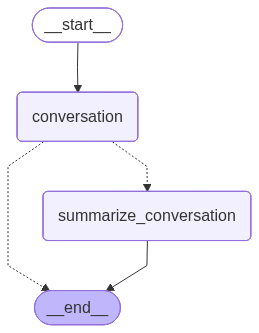

In [5]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START

# Определяем новый граф
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Устанавливаем точку входа
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Собираем
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

Теперь мы можем вызывать граф несколько раз.

In [10]:
import time
# Создаем поток
config = {"configurable": {"thread_id": "1"}}

# Начинаем разговор
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

time.sleep(2)

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

time.sleep(2)

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hello again, Lance! You've introduced yourself a couple of times now. Since you're a fan of the San Francisco 49ers, would you like to talk about the team? We could discuss their current roster, their history, or any other aspect of the team that interests you. What would you like to know or talk about?
================================== Ai Message ==================================

Your name is Lance. You've introduced yourself a few times during our conversation. Is there something specific about your name you'd like to discuss, or would you prefer to talk about the San Francisco 49ers, as you mentioned earlier?
================================== Ai Message ==================================

That's great to hear, Lance! The San Francisco 49ers have a rich history and a passionate fan base. Is there a specific aspect of the team you'd like to talk about? For example, we could discuss:

* The team's his

Давайте убедимся, что наше состояние сохранено локально.

In [11]:
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='c14e031f-27d9-4b5c-96ee-fd38a162a07f'), AIMessage(content="Hello again, Lance! You've introduced yourself a couple of times now. Since you're a fan of the San Francisco 49ers, would you like to talk about the team? We could discuss their current roster, their history, or any other aspect of the team that interests you. What would you like to know or talk about?", additional_kwargs={}, response_metadata={'token_usage': {'prompt_tokens': 338, 'total_tokens': 408, 'completion_tokens': 70}, 'model_name': 'mistral-small-latest', 'model': 'mistral-small-latest', 'finish_reason': 'stop', 'model_provider': 'mistralai'}, id='lc_run--a3ec3918-6767-4ed2-9a87-c27e419b3f7c-0', usage_metadata={'input_tokens': 338, 'output_tokens': 70, 'total_tokens': 408}), HumanMessage(content="what's my name?", additional_kwargs={}, response_metadata={}, id='3e9ac97d-70e1-4c3b-8f78-7a95d2cb1415'

### Сохранение состояния

Использование базы данных, такой как Sqlite, означает, что состояние сохраняется!

Например, мы можем перезапустить ядро блокнота и убедиться, что всё ещё можем загрузить данные из Sqlite БД на диске.


In [6]:
# Создаем поток
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='c14e031f-27d9-4b5c-96ee-fd38a162a07f'), AIMessage(content="Hello again, Lance! You've introduced yourself a couple of times now. Since you're a fan of the San Francisco 49ers, would you like to talk about the team? We could discuss their current roster, their history, or any other aspect of the team that interests you. What would you like to know or talk about?", additional_kwargs={}, response_metadata={'token_usage': {'prompt_tokens': 338, 'total_tokens': 408, 'completion_tokens': 70}, 'model_name': 'mistral-small-latest', 'model': 'mistral-small-latest', 'finish_reason': 'stop', 'model_provider': 'mistralai'}, id='lc_run--a3ec3918-6767-4ed2-9a87-c27e419b3f7c-0', usage_metadata={'input_tokens': 338, 'output_tokens': 70, 'total_tokens': 408}), HumanMessage(content="what's my name?", additional_kwargs={}, response_metadata={}, id='3e9ac97d-70e1-4c3b-8f78-7a95d2cb1415'

## Studio

**⚠️ Внимание**

После создания этих видео мы обновили Studio, и теперь её можно запускать локально и открывать в браузере. Это предпочтительный способ работы со Studio вместо использования Desktop App, показанного в видео. Теперь она называется _LangSmith Studio_ вместо _LangGraph Studio_. Подробные инструкции по настройке доступны в руководстве "Начало работы" в начале курса. Описание Studio можно найти [здесь](https://docs.langchain.com/langsmith/studio), а конкретные детали по локальному развертыванию — [здесь](https://docs.langchain.com/langsmith/quick-start-studio#local-development-server).

Чтобы запустить локальный сервер разработки, выполните следующую команду в терминале в директории `/studio` этого модуля:

```
langgraph dev
```

Вы должны увидеть следующий вывод:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Откройте браузер и перейдите по URL-адресу **Studio UI**, указанному выше.
Загрузите `chatbot` в Studio, который использует `module-2/studio/chatbot.py`, указанный в `module-2/studio/langgraph.json`.